In [1255]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 25 17:11:08 2019

@author: tony jiang
"""
#fafe
import csv
import itertools
import operator
import os
import sys
import re
from sentence_transformers import SentenceTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import graphviz
from scipy.sparse import hstack
from sklearn import tree
import pydot
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [1256]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Loading In Data

In [1257]:
# import data
path = os.path.join(os.path.expanduser("~"), "Documents", "lowe_house_price_prediction", "yelp_dataset")
#sys.path.insert(0, path)
#sys.path.insert(0, "C:\Users\mgelman\AppData\Local\Continuum\anaconda2\Library\bin\graphviz")

# LOAD BUSINESS DATA
inputfile = os.path.join(path, "business.json")
business_data = pd.read_json(inputfile, lines=True)
# keep a subset of variables
business_data = business_data[['business_id', 'postal_code', 'state', 'categories', 'attributes']]

In [1258]:
business_data.shape

(192609, 5)

# Filter Business to only Restaurants

In [1259]:
def filter_restaurants(attribute):
    if attribute:
        return 'RestaurantsPriceRange2' in attribute
    else:
        return False

In [1260]:
mask = business_data['attributes'].apply(filter_restaurants)
business_data = business_data[mask]
business_data = business_data[['business_id', 'postal_code', 'state', 'categories']]

In [1261]:
business_data.shape

(108179, 4)

In [1262]:
# trim the category text
business_data['categories'] = business_data['categories'].str.slice(stop=50)
business_data['categories'] = business_data['categories'].str.encode('ascii', errors='coerce')
#business_data['categories'] = business_data['categories'].str.replace('&', '')

# convert postal code to integers (will get rid of non-us zipcodes)
business_data['postal_code'] = pd.to_numeric(business_data['postal_code'], errors='coerce')
business_data.dropna(inplace=True)

In [1263]:
business_data.head(10)

,business_id,postal_code,state,categories
2,gnKjwL_1w79qoiV3IC_xQQ,28210.0,NC,"b'Sushi Bars, Restaurants, Japanese'"
7,gbQN7vr_caG_A1ugSmGhWg,89121.0,NV,"b""Hair Salons, Hair Stylists, Barbers, Men's H..."
8,Y6iyemLX_oylRpnr38vgMA,85308.0,AZ,"b'Nail Salons, Beauty & Spas, Day Spas'"
9,4GBVPIYRvzGh4K4TkRQ_rw,44126.0,OH,"b'Beauty & Spas, Nail Salons, Day Spas, Massage'"
11,1Dfx3zM-rW4n-31KeC8sJg,85016.0,AZ,"b'Restaurants, Breakfast & Brunch, Mexican, Ta..."
12,5t3KVdMnFgAYmSl1wYLhmA,28117.0,NC,"b'Bars, Nightlife, Pubs, Barbers, Beauty & Spa..."
13,fweCYi8FmbJXHCqLnwuk8w,44060.0,OH,"b'Italian, Restaurants, Pizza, Chicken Wings'"
14,-K4gAv8_vjx8-2BxkVeRkA,44094.0,OH,"b'Bakeries, Food'"
16,giC3pVVFxCRR89rApqklyw,85254.0,AZ,"b""Hair Stylists, Beauty & Spas, Hair Salons, M..."
17,PZ-LZzSlhSe9utkQYU8pFg,89119.0,NV,"b'Restaurants, Italian'"


In [1264]:
# LOAD IN REVIEW DATA (use unix command top to create a smaller version of the dataset)
# head -n NUMBEROFLINES file.json > mynewfile.json
# TO GET SPECIFIC YEAR
# grep -E '201[0|1|2]' review.json > review_2010-2012.json
# inputfile=os.path.join(path,"review.json")
inputfile = os.path.join(path, "review_10k.json")
outputfile = os.path.join(path, "review.pkl")
review_data = pd.read_json(inputfile, lines=True)
# only keep business_id, date, stars, text
review_data = review_data[['business_id', 'date', 'stars', 'text']]
# take out numbers in 'text'

#preprossing: taking out punctuations, numbers, special symbols

BERT = True
if BERT:
    review_data['text'] = review_data['text'].str.replace('[0-9]', '')
else:
    review_data['text'] = review_data['text'].str.replace(r'[1-9,.;@*#?!&$]+', '').str.lower()


In [1265]:
review_data['text']

0        Total bill for this horrible service? Over $Gs...
1        I *adore* Travis at the Hard Rock's new Kelly ...
2        I have to say that this office really has it t...
3        Went in for a lunch. Steak sandwich was delici...
4        Today was my second out of three sessions I ha...
                               ...                        
99995    I love the clothes in Aritzia. The service I c...
99996    We went here to have a small dinner with famil...
99997    Amazing!!! Our  boys never had this much fun !...
99998    Wanted a short hair cut but didn't have a regu...
99999    This place is rad! Dueling pianos, happy hour ...
Name: text, Length: 100000, dtype: object

In [1266]:
inputfile = os.path.join(path, "Zip_Zhvi_AllHomes.csv")
# zillow_data = pd.read_csv(inputfile, header=0, quoting=3)
zillow_data = pd.read_csv(inputfile, encoding='latin-1')

In [1267]:
zillow_data.head(100)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,168300.0,168400.0,168400.0,...,1054100,1032200,1019300,1014500,995100,978700,973800,975700,975700,973300
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,160000.0,161000.0,161700.0,...,353500,353500,354500,354300,352300,349700,347800,347200,346000,344500
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,353100.0,353700.0,354200.0,...,1380000,1375600,1376300,1369800,1364200,1375100,1403700,1413700,1415100,1422300
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,210400.0,212200.0,212200.0,...,335700,335100,334100,333500,333500,333400,331900,329600,327700,326700
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,194400.0,196100.0,197300.0,...,432600,433100,433800,432800,430700,428600,426000,423000,419900,419200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,79054,48197,Ypsilanti,MI,Ann Arbor,Washtenaw County,96,126900.0,127600.0,128400.0,...,222500,225000,227500,228300,228800,229300,229600,230000,230500,230900
96,77007,44107,Lakewood,OH,Cleveland-Elyria,Cuyahoga County,97,93700.0,94100.0,94500.0,...,188300,190100,192300,192400,189000,186400,187500,189300,190500,191800
97,87074,66062,Olathe,KS,Kansas City,Johnson County,98,107200.0,107400.0,107800.0,...,261300,262600,264200,265600,266400,266600,267000,267300,268300,269600
98,62022,11211,New York,NY,New York-Newark-Jersey City,Kings County,99,146000.0,146300.0,146500.0,...,961700,964600,969800,972700,974300,975900,977700,981100,982900,979800


# Data Wrangling on the Zillow Data

In [1268]:
# Drop some columns
zillow_data.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1, inplace=True)
# Make it such that: RegionName is the only identifier, the others are variable year then then value 
zillow_data = pd.melt(zillow_data, id_vars='RegionName', value_vars=list(zillow_data.columns.values)[1:])

In [1269]:
zillow_data.head(100)

,RegionName,variable,value
0,10025,1996-04,168300.0
1,60657,1996-04,160000.0
2,10023,1996-04,353100.0
3,77494,1996-04,210400.0
4,60614,1996-04,194400.0
...,...,...,...
95,48197,1996-04,126900.0
96,44107,1996-04,93700.0
97,66062,1996-04,107200.0
98,11211,1996-04,146000.0


In [1270]:
# generate datetime
zillow_data['date'] = pd.to_datetime(zillow_data['variable'])
zillow_data['year'] = zillow_data['date'].dt.year

In [1271]:
zillow_data.head(10)

,RegionName,variable,value,date,year
0,10025,1996-04,168300.0,1996-04-01,1996
1,60657,1996-04,160000.0,1996-04-01,1996
2,10023,1996-04,353100.0,1996-04-01,1996
3,77494,1996-04,210400.0,1996-04-01,1996
4,60614,1996-04,194400.0,1996-04-01,1996
5,77449,1996-04,95400.0,1996-04-01,1996
6,10002,1996-04,NaN,1996-04-01,1996
7,77084,1996-04,94700.0,1996-04-01,1996
8,79936,1996-04,77200.0,1996-04-01,1996
9,60640,1996-04,99400.0,1996-04-01,1996


In [1272]:
# get yearly mean
zillow_yearly_avg = zillow_data.groupby(['RegionName', 'year'])['value'].mean().reset_index()

In [1273]:
zillow_yearly_avg.head(10)

,RegionName,year,value
0,1001,1996,104900.000000
1,1001,1997,107283.333333
2,1001,1998,111050.000000
3,1001,1999,114000.000000
4,1001,2000,120416.666667
5,1001,2001,129525.000000
6,1001,2002,140400.000000
7,1001,2003,153458.333333
8,1001,2004,171991.666667
9,1001,2005,197291.666667


# Merge Yelp and Zillow Data

In [1274]:
# %% Merge everyting together

# First merge the yelp data to get zipcode
yelp_merged = review_data.merge(business_data, left_on='business_id', right_on='business_id', how='inner',
                                validate="m:1")
yelp_merged['year'] = pd.to_datetime(yelp_merged['date']).dt.year

In [1275]:
# At this point, each row of the yelp data still just corresponds to a single review  
yelp_merged.head(10)

,business_id,date,stars,text,postal_code,state,categories,year
0,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,I *adore* Travis at the Hard Rock's new Kelly ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-06-17 17:01:16,5,I usually go to the Fort Apache location and t...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
2,NZnhc2sEQy3RmzKTZnqtwQ,2017-12-29 22:32:42,5,"Awesome , great experience. Got exactly what ...",89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
3,NZnhc2sEQy3RmzKTZnqtwQ,2016-12-04 07:04:07,5,I've gotten my haircut from Sara for at least ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2016
4,NZnhc2sEQy3RmzKTZnqtwQ,2017-12-17 07:55:14,5,Once I got a haircut from Yanira I haven't gon...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
5,NZnhc2sEQy3RmzKTZnqtwQ,2017-03-04 00:27:43,4,Loving the new salon! its really pretty in the...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
6,NZnhc2sEQy3RmzKTZnqtwQ,2017-04-30 23:05:43,5,I first saw YANIRA at the other location but a...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
7,NZnhc2sEQy3RmzKTZnqtwQ,2017-02-09 08:31:27,5,After years of a very high maintenance multip...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017
8,NZnhc2sEQy3RmzKTZnqtwQ,2016-11-11 22:19:27,5,I am super ecstatic to rave about this place. ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2016
9,NZnhc2sEQy3RmzKTZnqtwQ,2016-12-20 16:46:43,5,I've been visiting the Fort Apache salon for s...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2016


In [1276]:
# merge current yelp with zillow based on postal code and year 
final_data = yelp_merged.merge(zillow_yearly_avg, left_on=['postal_code', 'year'], right_on=['RegionName', 'year'],
                               how='left', validate="m:1")
final_data.dropna(inplace=True)

#csv_file_name = os.path.join(path, "yelp_zillow.tsv")
#final_data[['year', 'stars', 'postal_code', 'state', 'value']].to_csv(csv_file_name, sep='\t', encoding='utf-8',
#                                                                      index=False, quoting=csv.QUOTE_NONE)

In [1277]:
# Again, current merged data, at this point, has every row map to a distinct review text. The value column is the average housing price of that year  
final_data.head(10)

,business_id,date,stars,text,postal_code,state,categories,year,RegionName,value
0,NZnhc2sEQy3RmzKTZnqtwQ,2017-01-14 21:30:33,5,I *adore* Travis at the Hard Rock's new Kelly ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
1,NZnhc2sEQy3RmzKTZnqtwQ,2017-06-17 17:01:16,5,I usually go to the Fort Apache location and t...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
2,NZnhc2sEQy3RmzKTZnqtwQ,2017-12-29 22:32:42,5,"Awesome , great experience. Got exactly what ...",89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
3,NZnhc2sEQy3RmzKTZnqtwQ,2016-12-04 07:04:07,5,I've gotten my haircut from Sara for at least ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2016,89169.0,136450.0
4,NZnhc2sEQy3RmzKTZnqtwQ,2017-12-17 07:55:14,5,Once I got a haircut from Yanira I haven't gon...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
5,NZnhc2sEQy3RmzKTZnqtwQ,2017-03-04 00:27:43,4,Loving the new salon! its really pretty in the...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
6,NZnhc2sEQy3RmzKTZnqtwQ,2017-04-30 23:05:43,5,I first saw YANIRA at the other location but a...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
7,NZnhc2sEQy3RmzKTZnqtwQ,2017-02-09 08:31:27,5,After years of a very high maintenance multip...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2017,89169.0,152050.0
8,NZnhc2sEQy3RmzKTZnqtwQ,2016-11-11 22:19:27,5,I am super ecstatic to rave about this place. ...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2016,89169.0,136450.0
9,NZnhc2sEQy3RmzKTZnqtwQ,2016-12-20 16:46:43,5,I've been visiting the Fort Apache salon for s...,89169.0,NV,"b'Beauty & Spas, Hair Stylists, Makeup Artists...",2016,89169.0,136450.0


# Aggregate

In [1278]:
# First aggregate to zip year
# create the dictionary for the collapse (mapping from var to agg type)

# group by creates a mapping from the user_id to the row index. Ie, user 1 maps to rows 4,5,6, user 2 maps to rows 7,8,9.
data_group = final_data.groupby(['postal_code', 'year'], as_index=False)

In [1279]:
# aggregate in groups depending on the var type
# group 1: numerical variables
mean = ['value', 'stars']

# group 2: retain all strings
all = ['text']

# group 3: ID vars: like state
first = ['state']

# create the dictionary for the collapse (mapping from var to agg type)
d = {}
d_agg_type = {'first': first,
              np.nanmean: mean,
              lambda x: " ".join(x): all}

In [1280]:
d_agg_type.items()

dict_items([('first', ['state']), (<function nanmean at 0x10c854598>, ['value', 'stars']), (<function <lambda> at 0x1bc7a24840>, ['text'])])

In [1281]:
#key is the function, value is the column names 
for key, value in d_agg_type.items():
    for col in value:
        d.update({col: key})

In [1282]:
#specify the way of aggregartion per column
d

{'state': 'first',
 'value': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'stars': <function numpy.nanmean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
 'text': <function __main__.<lambda>(x)>}

In [1283]:
# collapse data
final_data_collapsed = data_group.agg(d)

In [1284]:
#at this point, each row is distinct by postal_code and year, the value is the average house price, stars is the average stars, and text is all the reviews combined 
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text
0,12979.0,2011,NY,114250.000000,5.000000,Lakeside Cafe is THE stop on our bicycle rides...
1,12979.0,2012,NY,113800.000000,4.000000,You know what I like about Lakeside? Everythin...
2,12979.0,2013,NY,116175.000000,4.000000,This the Third year in a row I've come up from...
3,12979.0,2018,NY,130358.333333,5.000000,What a great place! We were so happy to have l...
4,15003.0,2012,PA,56000.000000,5.000000,Police Station Pizza is a great local favorite...
5,15003.0,2013,PA,60483.333333,5.000000,There is nothing fancy about this place - it i...
6,15003.0,2014,PA,54800.000000,4.500000,I go here for the filipino food they serve whi...
7,15003.0,2015,PA,56175.000000,1.000000,"Sorry to say, Nelias did not live up to the ot..."
8,15017.0,2011,PA,133175.000000,5.000000,This particular location has the best service ...
9,15017.0,2013,PA,132300.000000,2.909091,"The concept is a good idea, the execution make..."


# Calculate Changes 

In [1285]:
final_data_collapsed['text']

0       Lakeside Cafe is THE stop on our bicycle rides...
1       You know what I like about Lakeside? Everythin...
2       This the Third year in a row I've come up from...
3       What a great place! We were so happy to have l...
4       Police Station Pizza is a great local favorite...
                              ...                        
3027    The workers are awesome they always ask if I n...
3028    I had been a customer at this Ulta for several...
3029    I absolutely loved my experience with them! An...
3030    This company is professional & prompt! \nI mes...
3031    I have an event on Saturday and I'm wearing wh...
Name: text, Length: 3032, dtype: object

In [1286]:
# create log prices
final_data_collapsed['log_price'] = np.log(final_data_collapsed['value'])

# NEED TO SORT TO GET DIFF
final_data_collapsed.sort_values(['postal_code', 'year'], inplace=True)

In [1287]:
#Create embeddings 
if BERT:
    #### BERT Embedding
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    sentence_embeddings = model.encode(final_data_collapsed['text'])
    word_df = pd.concat([final_data_collapsed[['postal_code', 'year']], pd.DataFrame(sentence_embeddings)], axis=1)
    ####
else:
    vectorizer = TfidfVectorizer(ngram_range=(1, 1),
                                 stop_words='english',
                                 min_df=30)
    X_test = vectorizer.fit_transform(final_data_collapsed['text'])
    # add the zipcode and year to the words
    word_df = pd.concat([final_data_collapsed[['postal_code', 'year']], pd.DataFrame(X_test.todense())], axis=1)

In [1288]:
# word_df is a feature vector of reviews + corresponding postal_code and year 
word_df.head(10)

,postal_code,year,0,1,2,3,4,5,6,7,...,758,759,760,761,762,763,764,765,766,767
0,12979.0,2011,-1.184730,0.286891,0.563158,0.139934,0.443244,-1.002409,-0.337606,0.273052,...,-0.747541,-0.956811,-0.952932,-0.695469,-0.009460,-1.217767,-0.136493,-0.308892,-0.616680,-0.133618
1,12979.0,2012,-0.359833,0.597697,0.898132,0.096963,0.444195,-1.128969,-0.135544,0.152265,...,-0.519000,-1.836470,-1.152778,-1.099471,-0.176792,-0.958005,-0.013521,0.637107,-0.340432,0.414894
2,12979.0,2013,-0.909355,0.287704,0.896220,-0.380309,0.299087,-1.397539,0.440395,-0.091102,...,-0.299878,-1.261403,-1.419331,-0.483147,-0.006563,-0.763480,0.277965,0.208802,0.163768,-0.014530
3,12979.0,2018,-0.683891,0.411898,0.446415,0.115728,0.025390,-1.306273,-0.563900,0.551161,...,-0.660883,-1.668266,-0.795620,-1.515585,-0.089979,-0.912388,0.133445,0.864684,-0.140549,-0.093390
4,15003.0,2012,-0.612259,0.608207,0.147065,-0.292129,-0.178618,-0.576700,0.270640,0.539445,...,-0.567066,-1.232925,-0.732576,-1.427573,-0.161291,-0.045674,0.341066,0.178622,-0.099623,0.049023
5,15003.0,2013,-0.539967,0.764821,-0.108142,0.027237,-0.097354,-0.468628,0.105508,0.774360,...,-0.366214,-1.086379,-0.831269,-1.462569,0.109915,-0.218376,-0.115643,0.939527,0.202211,0.215686
6,15003.0,2014,-0.491597,0.516640,-0.422819,-0.358733,-0.133727,-0.581955,-0.470969,0.278180,...,-0.532256,-1.346123,-0.877816,-1.734449,0.039767,-0.341290,0.066496,0.552369,0.312985,-0.015802
7,15003.0,2015,-0.310917,1.182730,-0.581215,-0.325138,-0.101998,-0.064783,0.569600,0.282383,...,-0.366261,-0.437075,-0.835642,-1.703214,-0.066895,-0.657305,-0.067676,0.102478,0.697560,0.264273
8,15017.0,2011,-0.973853,0.608896,0.064557,0.229504,-0.170397,-0.867365,-0.460697,0.664066,...,-0.759420,-1.497490,-0.755823,-1.743130,-0.210489,-0.643307,0.144644,-0.013902,0.261689,0.090551
9,15017.0,2013,-0.335384,0.570031,0.276634,-0.322137,0.362802,-0.459867,0.213192,0.467598,...,-0.577380,-1.642813,-0.838585,-1.958338,0.208091,-0.669672,0.137084,0.302894,-0.021207,0.278962


In [1289]:
# take the difference within rows with the same postal_code 
word_df = word_df.groupby(['postal_code']).diff()

In [1290]:
# Each row taking a difference to the row before. NaN happens when previous row doesn't exist or doesn't have the same postal code  
word_df.head(10)

,year,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,0.824897,0.310806,0.334974,-0.042971,0.000950,-0.126559,0.202062,-0.120787,-0.274022,...,0.228540,-0.879658,-0.199846,-0.404002,-0.167332,0.259762,0.122972,0.946000,0.276248,0.548512
2,1.0,-0.549522,-0.309994,-0.001912,-0.477273,-0.145108,-0.268570,0.575940,-0.243367,0.063133,...,0.219122,0.575066,-0.266553,0.616324,0.170229,0.194525,0.291486,-0.428305,0.504201,-0.429424
3,5.0,0.225464,0.124195,-0.449805,0.496037,-0.273697,0.091266,-1.004295,0.642263,0.314211,...,-0.361005,-0.406862,0.623711,-1.032438,-0.083416,-0.148908,-0.144520,0.655881,-0.304317,-0.078860
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.072293,0.156614,-0.255208,0.319365,0.081265,0.108072,-0.165131,0.234915,-0.318739,...,0.200852,0.146546,-0.098692,-0.034996,0.271206,-0.172702,-0.456710,0.760905,0.301834,0.166663
6,1.0,0.048370,-0.248180,-0.314677,-0.385969,-0.036373,-0.113327,-0.576477,-0.496179,0.345641,...,-0.166042,-0.259745,-0.046547,-0.271880,-0.070148,-0.122915,0.182139,-0.387158,0.110775,-0.231488
7,1.0,0.180680,0.666089,-0.158396,0.033595,0.031728,0.517172,1.040568,0.004203,0.203768,...,0.165995,0.909049,0.042173,0.031236,-0.106662,-0.316015,-0.134172,-0.449892,0.384575,0.280075
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.0,0.638468,-0.038865,0.212077,-0.551642,0.533199,0.407498,0.673889,-0.196468,-0.459682,...,0.182040,-0.145323,-0.082762,-0.215208,0.418580,-0.026365,-0.007560,0.316796,-0.282896,0.188412


In [1291]:
# only keep one year difference
word_df = word_df.loc[word_df['year'] == 1]
# drop the column and covert back to sparse matrix
word_df.drop(['year'], axis=1, inplace=True)
X_words = scipy.sparse.csr_matrix(word_df.values)

In [1292]:
#the review df only has rows that were about 1 year difference in its own group
word_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
1,0.824897,0.310806,0.334974,-0.042971,0.000950,-0.126559,0.202062,-0.120787,-0.274022,0.114868,...,0.228540,-0.879658,-0.199846,-0.404002,-0.167332,0.259762,0.122972,0.946000,0.276248,0.548512
2,-0.549522,-0.309994,-0.001912,-0.477273,-0.145108,-0.268570,0.575940,-0.243367,0.063133,0.060989,...,0.219122,0.575066,-0.266553,0.616324,0.170229,0.194525,0.291486,-0.428305,0.504201,-0.429424
5,0.072293,0.156614,-0.255208,0.319365,0.081265,0.108072,-0.165131,0.234915,-0.318739,-0.317510,...,0.200852,0.146546,-0.098692,-0.034996,0.271206,-0.172702,-0.456710,0.760905,0.301834,0.166663
6,0.048370,-0.248180,-0.314677,-0.385969,-0.036373,-0.113327,-0.576477,-0.496179,0.345641,-0.124955,...,-0.166042,-0.259745,-0.046547,-0.271880,-0.070148,-0.122915,0.182139,-0.387158,0.110775,-0.231488
7,0.180680,0.666089,-0.158396,0.033595,0.031728,0.517172,1.040568,0.004203,0.203768,0.210283,...,0.165995,0.909049,0.042173,0.031236,-0.106662,-0.316015,-0.134172,-0.449892,0.384575,0.280075
10,-0.372963,-0.133514,0.280177,0.321569,-0.157848,-0.342632,0.178892,-0.154181,0.068840,-0.124169,...,0.118830,-0.022885,-0.448232,0.075268,0.117234,-0.292052,0.284812,0.315293,0.130906,-0.415717
11,0.478873,-0.226818,-0.269474,0.042640,0.227332,0.424596,0.105208,0.267414,-0.390083,-0.095480,...,-0.013231,0.831721,0.002079,0.791366,-0.127913,0.403391,-0.148592,-0.161854,0.085150,0.326447
12,-0.200047,0.059694,-0.363046,-0.071019,-0.608585,-0.465226,-0.105865,0.077434,0.313881,-0.364567,...,-0.158794,-0.827043,0.057065,-0.411192,-0.143493,0.172675,-0.071245,0.082748,-0.446859,-0.226267
13,0.086541,0.152870,0.716873,0.047559,0.148763,0.156909,0.460603,-0.714693,0.057544,0.378271,...,-0.445052,0.487227,-0.120411,-0.263603,0.080501,-0.219018,0.027423,0.015826,0.100806,0.195310
14,0.282680,0.180713,-0.302756,0.102356,0.431777,0.060516,0.364213,0.684427,-0.443699,0.080343,...,0.598312,0.288415,0.346759,0.737456,0.153237,0.416751,0.149304,-0.102292,0.189207,-0.102509


In [1293]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price
0,12979.0,2011,NY,114250.000000,5.000000,Lakeside Cafe is THE stop on our bicycle rides...,11.646144
1,12979.0,2012,NY,113800.000000,4.000000,You know what I like about Lakeside? Everythin...,11.642198
2,12979.0,2013,NY,116175.000000,4.000000,This the Third year in a row I've come up from...,11.662853
3,12979.0,2018,NY,130358.333333,5.000000,What a great place! We were so happy to have l...,11.778042
4,15003.0,2012,PA,56000.000000,5.000000,Police Station Pizza is a great local favorite...,10.933107
5,15003.0,2013,PA,60483.333333,5.000000,There is nothing fancy about this place - it i...,11.010123
6,15003.0,2014,PA,54800.000000,4.500000,I go here for the filipino food they serve whi...,10.911445
7,15003.0,2015,PA,56175.000000,1.000000,"Sorry to say, Nelias did not live up to the ot...",10.936227
8,15017.0,2011,PA,133175.000000,5.000000,This particular location has the best service ...,11.799419
9,15017.0,2013,PA,132300.000000,2.909091,"The concept is a good idea, the execution make...",11.792827


In [1294]:
# sort by postal_code, year
final_data_collapsed[['D_LP', 'D_stars', 'D_year']] = final_data_collapsed.groupby(['postal_code'])[
    'log_price', 'stars', 'year'].diff()

In [1295]:
# the difference is current year value - previous year value 
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year
0,12979.0,2011,NY,114250.000000,5.000000,Lakeside Cafe is THE stop on our bicycle rides...,11.646144,NaN,NaN,NaN
1,12979.0,2012,NY,113800.000000,4.000000,You know what I like about Lakeside? Everythin...,11.642198,-0.003947,-1.000000,1.0
2,12979.0,2013,NY,116175.000000,4.000000,This the Third year in a row I've come up from...,11.662853,0.020655,0.000000,1.0
3,12979.0,2018,NY,130358.333333,5.000000,What a great place! We were so happy to have l...,11.778042,0.115189,1.000000,5.0
4,15003.0,2012,PA,56000.000000,5.000000,Police Station Pizza is a great local favorite...,10.933107,NaN,NaN,NaN
5,15003.0,2013,PA,60483.333333,5.000000,There is nothing fancy about this place - it i...,11.010123,0.077016,0.000000,1.0
6,15003.0,2014,PA,54800.000000,4.500000,I go here for the filipino food they serve whi...,10.911445,-0.098678,-0.500000,1.0
7,15003.0,2015,PA,56175.000000,1.000000,"Sorry to say, Nelias did not live up to the ot...",10.936227,0.024782,-3.500000,1.0
8,15017.0,2011,PA,133175.000000,5.000000,This particular location has the best service ...,11.799419,NaN,NaN,NaN
9,15017.0,2013,PA,132300.000000,2.909091,"The concept is a good idea, the execution make...",11.792827,-0.006592,-2.090909,2.0


In [1296]:
# only keep if the difference in year is 1. Or else we are missing data
final_data_collapsed = final_data_collapsed.loc[final_data_collapsed['D_year'] == 1]  # type: object

In [1297]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year
1,12979.0,2012,NY,113800.000000,4.000000,You know what I like about Lakeside? Everythin...,11.642198,-0.003947,-1.000000,1.0
2,12979.0,2013,NY,116175.000000,4.000000,This the Third year in a row I've come up from...,11.662853,0.020655,0.000000,1.0
5,15003.0,2013,PA,60483.333333,5.000000,There is nothing fancy about this place - it i...,11.010123,0.077016,0.000000,1.0
6,15003.0,2014,PA,54800.000000,4.500000,I go here for the filipino food they serve whi...,10.911445,-0.098678,-0.500000,1.0
7,15003.0,2015,PA,56175.000000,1.000000,"Sorry to say, Nelias did not live up to the ot...",10.936227,0.024782,-3.500000,1.0
10,15017.0,2014,PA,138266.666667,3.500000,Came here on a date night with my girlfriend ...,11.836939,0.044112,0.590909,1.0
11,15017.0,2015,PA,146291.666667,2.333333,"Bad location, worse food and poor service. Kin...",11.893358,0.056418,-1.166667,1.0
12,15017.0,2016,PA,152375.000000,3.062500,I have NEVER had a bad meal there! Larissa has...,11.934100,0.040742,0.729167,1.0
13,15017.0,2017,PA,162141.666667,3.210526,We've been putting off coming here because my ...,11.996226,0.062126,0.148026,1.0
14,15017.0,2018,PA,170575.000000,2.777778,My friends and I went to Rumfish on Cinco de M...,12.046930,0.050705,-0.432749,1.0


# Create Categories for Y 

In [1298]:
# Create D_LP categories by quantile
#final_data_collapsed['D_LP_CAT'] = pd.qcut(final_data_collapsed['D_LP'].values, 3).codes
# Create two categories: if change in price is positive or not 
final_data_collapsed['D_LP_CAT'] = np.where(final_data_collapsed['D_LP'] >= 0, 1,0)

# Some Summary Stats of the Final Dataset

In [1299]:
# confirm the correct split
final_data_collapsed['D_LP_CAT'].value_counts(normalize=True, sort=False)

0    0.231657
1    0.768343
Name: D_LP_CAT, dtype: float64

In [1300]:
# log price describe
final_data_collapsed['D_LP'].describe()

count    2426.000000
mean        0.037220
std         0.103670
min        -0.542478
25%         0.005451
50%         0.054490
75%         0.089941
max         0.368582
Name: D_LP, dtype: float64

In [1301]:
# state data distribution 
final_data_collapsed['state'].value_counts(normalize=True, sort=True)

AZ    0.346661
NV    0.165705
OH    0.163232
NC    0.122836
PA    0.120363
WI    0.047815
IL    0.023083
SC    0.009481
NY    0.000824
Name: state, dtype: float64

In [1302]:
# this is simply for me to see how the categories are created 
pd.qcut(final_data_collapsed['D_LP'].values, 3)


[(-0.543, 0.0273], (-0.543, 0.0273], (0.0751, 0.369], (-0.543, 0.0273], (-0.543, 0.0273], ..., (0.0751, 0.369], (0.0751, 0.369], (0.0751, 0.369], (0.0751, 0.369], (0.0273, 0.0751]]
Length: 2426
Categories (3, interval[float64]): [(-0.543, 0.0273] < (0.0273, 0.0751] < (0.0751, 0.369]]

In [1303]:
final_data_collapsed.head(10)

,postal_code,year,state,value,stars,text,log_price,D_LP,D_stars,D_year,D_LP_CAT
1,12979.0,2012,NY,113800.000000,4.000000,You know what I like about Lakeside? Everythin...,11.642198,-0.003947,-1.000000,1.0,0
2,12979.0,2013,NY,116175.000000,4.000000,This the Third year in a row I've come up from...,11.662853,0.020655,0.000000,1.0,1
5,15003.0,2013,PA,60483.333333,5.000000,There is nothing fancy about this place - it i...,11.010123,0.077016,0.000000,1.0,1
6,15003.0,2014,PA,54800.000000,4.500000,I go here for the filipino food they serve whi...,10.911445,-0.098678,-0.500000,1.0,0
7,15003.0,2015,PA,56175.000000,1.000000,"Sorry to say, Nelias did not live up to the ot...",10.936227,0.024782,-3.500000,1.0,1
10,15017.0,2014,PA,138266.666667,3.500000,Came here on a date night with my girlfriend ...,11.836939,0.044112,0.590909,1.0,1
11,15017.0,2015,PA,146291.666667,2.333333,"Bad location, worse food and poor service. Kin...",11.893358,0.056418,-1.166667,1.0,1
12,15017.0,2016,PA,152375.000000,3.062500,I have NEVER had a bad meal there! Larissa has...,11.934100,0.040742,0.729167,1.0,1
13,15017.0,2017,PA,162141.666667,3.210526,We've been putting off coming here because my ...,11.996226,0.062126,0.148026,1.0,1
14,15017.0,2018,PA,170575.000000,2.777778,My friends and I went to Rumfish on Cinco de M...,12.046930,0.050705,-0.432749,1.0,1


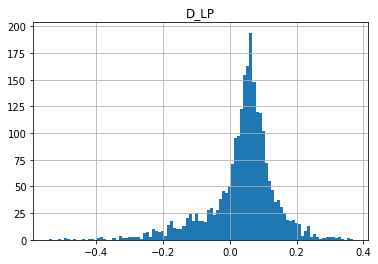

In [1304]:
# histogram
final_data_collapsed.hist(column='D_LP', bins=100)
plt.show()
del review_data, business_data, zillow_data

# Models

In [1305]:
# %% Create testing,training dataset

# define y-lp_cat and X-change in text feature vector, average stars. 

y_data = final_data_collapsed['D_LP_CAT']
X_data = final_data_collapsed[['D_stars']]

In [1306]:
# split into training and test
X_train, X_test, y_train, y_test, X_words_train, X_words_test = train_test_split(
    X_data, y_data, X_words, test_size=0.25, random_state=1234)

In [1307]:
# Add in stars and yelp categories as features (text feature vector is numpy, X_train is df)
X_tr = hstack([X_words_train, np.matrix(X_train)])
X_te = hstack([X_words_test, np.matrix(X_test)])

In [1308]:
X_tra = np.matrix(X_train)
X_tes = np.matrix(X_test)

In [1309]:
if not BERT: 
    vocab = vectorizer.get_feature_names()
    vocab_str = [str(x.encode('utf-8')) for x in vocab]

# Tree Classifier

In [1310]:
# Use the tree classifier
clf = DecisionTreeClassifier()
# clf = RandomForestClassifier(
#                n_estimators=128,
#                n_jobs=-1,
#                verbose=1)

# clf = DecisionTreeClassifier(max_leaf_nodes=15)

clf = clf.fit(X_tr, y_train)

In [1311]:
if False:
    sum_words = X_tr.sum(axis=0) #sum up a words vector values across all the rows 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

    #Look a Top X frequent words
    for word, freq in words_freq[:10]:
       print(word, freq)  

Normalized confusion matrix
[[0.29 0.71]
 [0.21 0.79]]


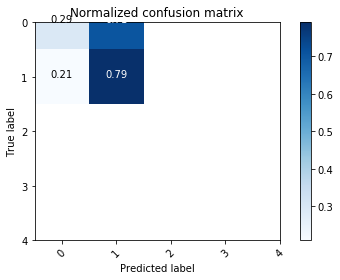

In [1312]:
y_pred = clf.predict(X_te)

# confusion matrix
# create label
price_label = [0, 1,2,3,4]
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')

In [1313]:
# features are the text labels, then STARS
# if not BERT:
#     feat_str = vocab_str + ["stars"]
#     dictionary = dict(zip(feat_str, clf.feature_importances_))
#     sorted_x = sorted(dictionary.items(), key=operator.itemgetter(1), reverse=True)
#     for x in range(20):
#         print(sorted_x[x])

# overall score
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %%
# Graph the tree
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


the training_score is 1.0

the testing_score is 0.6721581548599671


In [1314]:
#export tree diagram
if not BERT:
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file=dot_data,
                         feature_names=feat_str,
                         filled=True, rounded=True, special_characters=True,
                         )

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graphfile = os.path.join(path, "fig", "graph_v2.pdf")
    graph.write_pdf(graphfile)

# Naive Bayes

In [1315]:
# %%
# from sklearn.naive_bayes import MultinomialNB
#
# clf = MultinomialNB().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# # cm=confusion_matrix(y_test, y_pred)
# # np.set_printoptions(precision=2)
# # plot_confusion_matrix(cm, classes=star_label,normalize=True,title='Normalized confusion matrix')
#
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
# neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
# pos_class_prob_sorted = clf.feature_log_prob_[4, :].argsort()
#
# print(np.take(feat_str, neg_class_prob_sorted[-10:]))
# print(np.take(feat_str, pos_class_prob_sorted[-10:]))

# %%
# from sklearn.svm import LinearSVC
#
# clf = LinearSVC().fit(X_tr, y_train)  # classifying transformed text data to target value
#
# # confusion matrix
# y_pred = clf.predict(X_te)
# cm = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)
# plot_confusion_matrix(cm, classes=price_label, normalize=True, title='Normalized confusion matrix')
#
# # calculating the mean accuracy on the given test data and labels
# training_score = clf.score(X_tr, y_train, sample_weight=None)
# testing_score = clf.score(X_te, y_test, sample_weight=None)
# print()
# print("the training_score is " + str(training_score))
# print()
# print("the testing_score is " + str(testing_score))
#
#
# def plot_coefficients(classifier, feature_names, top_features=10):
#     lowstar_coef = classifier.coef_[0, :] * -1
#     highstar_coef = classifier.coef_[4, :]
#     top_positive_coefficients = np.argsort(highstar_coef)[-top_features:]
#     top_negative_coefficients = np.argsort(lowstar_coef)[:top_features]
#     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#     # create plot
#     plt.figure(figsize=(15, 5))
#     colors = ['red' if c < 0 else 'blue' for c in
#               np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]])]
#     plt.bar(np.arange(2 * top_features),
#             np.hstack([lowstar_coef[top_negative_coefficients], highstar_coef[top_positive_coefficients]]),
#             color=colors)
#     feature_names = np.array(feature_names)
#     plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60)
#     plt.show()
#
#
# plot_coefficients(clf, feat_str)
# # plot_coefficients(clf, vocab,star_type=4)

In [1316]:
# %%
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)

clf = clf.fit(X_tr, y_train)

# calculating the mean accuracy on the given test data and labels
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

# %% Compare all the different types

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(),
    # NuSVC(probability=True),
    # GaussianNB(),
    # MultinomialNB(),
    LinearDiscriminantAnalysis(),
    #QuadraticDiscriminantAnalysis(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=8, n_jobs=-1, verbose=1),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

denseclass = ['GaussianNB', 'LinearDiscriminantAnalysis', 'QuadraticDiscriminantAnalysis']

for clf in classifiers:

    name = clf.__class__.__name__
    if name in denseclass:
        X_train = X_tr.toarray()
        X_test = X_te.toarray()
    else:
        X_train = X_tr
        X_test = X_te

    clf.fit(X_train, y_train)

    print("=" * 30)
    print(name)

    print('****Results****')
    training_score = clf.score(X_train, y_train, sample_weight=None)
    acc = clf.score(X_test, y_test, sample_weight=None)
    print("the training_score is " + str(training_score))
    print("Accuracy: {:.4%}".format(acc))

    log_entry = pd.DataFrame([[name, acc * 100]], columns=log_cols)
    log = log.append(log_entry)

print("=" * 30)

print(log.sort_values(by='Accuracy', ascending=False))


the training_score is 0.9571192963166575

the testing_score is 0.6589785831960461
KNeighborsClassifier
****Results****
the training_score is 0.822979659153381
Accuracy: 72.3229%


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC
****Results****
the training_score is 0.8614623419461243
Accuracy: 63.7562%


//anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis
****Results****
the training_score is 0.8532160527762507
Accuracy: 60.7908%
DecisionTreeClassifier
****Results****
the training_score is 1.0
Accuracy: 66.3921%


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished


RandomForestClassifier
****Results****


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished


the training_score is 0.9868059373282023
Accuracy: 69.5222%
AdaBoostClassifier
****Results****
the training_score is 0.8218801539307312
Accuracy: 72.9819%
GradientBoostingClassifier
****Results****
the training_score is 0.897196261682243
Accuracy: 76.6063%
                   Classifier   Accuracy
0  GradientBoostingClassifier  76.606260
0          AdaBoostClassifier  72.981878
0        KNeighborsClassifier  72.322900
0      RandomForestClassifier  69.522241
0      DecisionTreeClassifier  66.392092
0                   LinearSVC  63.756178
0  LinearDiscriminantAnalysis  60.790774


In [1317]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_tr, y_train)
# overall score
training_score = clf.score(X_tr, y_train, sample_weight=None)
testing_score = clf.score(X_te, y_test, sample_weight=None)
print()
print("the training_score is " + str(training_score))
print()
print("the testing_score is " + str(testing_score))

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



the training_score is 0.8290269378779549

the testing_score is 0.6869851729818781


# Playground

In [725]:
model = SentenceTransformer('bert-base-nli-mean-tokens')
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']
sentence_embeddings = model.encode(sentences)

In [726]:
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-1.04e-01  5.27e-01  1.18e+00  1.94e-01  1.59e-01  5.46e-01  2.82e-01
  1.22e-01  2.92e-01 -3.37e-01 -2.50e-01  2.93e-01  1.43e-01  3.80e-01
 -2.52e-01 -2.62e-01 -2.70e-01  4.68e-02  3.57e-01 -3.58e-01 -2.89e-02
  6.85e-02 -7.85e-01 -2.62e-01  1.03e+00 -4.06e-01  1.94e-01 -1.66e-01
 -2.90e-01 -1.08e-01 -6.31e-01 -4.69e-01  7.16e-01 -9.49e-01 -2.95e-02
  1.38e-02  7.03e-02 -2.72e-02 -6.25e-02 -5.85e-01 -9.02e-01 -9.56e-01
  4.95e-01  1.95e-04 -1.52e+00 -6.87e-01 -9.08e-01 -1.80e-01 -6.49e-01
 -2.97e-02 -1.83e+00  1.43e-01  1.94e-01  1.91e-02 -4.56e-01  9.45e-01
  1.66e-01 -1.41e+00  1.09e-01  2.16e-01 -2.48e-01 -2.69e-01  4.75e-01
  6.71e-01 -1.79e-02 -1.36e-01  5.70e-01 -7.20e-01 -1.11e+00 -3.17e-01
  4.56e-02 -4.46e-01 -1.10e-01  5.11e-01 -1.01e+00  3.37e-02 -4.45e-01
  8.89e-01  3.47e-01 -1.44e-01 -5.67e-01  1.15e-01  8.79e-01 -1.10e-03
  1.01e+00 -4.50e-01  6.43e-01 -7.58e-02 -1.19e+00  7.20e-01  4.31e